### Import all necessary libraries

In [6]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tensorflow.keras import layers
from tensorflow import keras
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from callbacks import CosineAnnealingScheduler
from utils import GroupConv2D, ConvMixer, SpatialShuffle

SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = "tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
TEST_DIR   = os.path.join(DATA_DIR, "test")


tf.config.optimizer.set_jit(False)
tf.keras.mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_experimental_options({
    "layout_optimizer": False,
    "remapping": False,
    "auto_mixed_precision": False,  # Metal handles fp16 itself
})


### Load Data and Preprocessing Functions

In [7]:
# -----------------------------
# CONFIG
# -----------------------------
IMG_SIZE = 64
BATCH_SIZE = 128
NUM_CLASSES = 200
AUTOTUNE = tf.data.AUTOTUNE

IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], tf.float32)
IMAGENET_STD  = tf.constant([0.229, 0.224, 0.225], tf.float32)

AUG = dict(
    jitter_prob=0.8,
    jitter_strength=0.2,
    cutout_prob=0.7,
    cutout_hw=16,
    fp16=True,
    normalize="meanstd",
)

MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 0.2
MIX_PROB = 0.5
CUTMIX_PROB = 0.5

# -----------------------------
# 1. Load class info
# -----------------------------
with open(os.path.join(DATA_DIR, "wnids.txt")) as f:
    class_names = [line.strip() for line in f.readlines()]

class_to_index = {name: i for i, name in enumerate(class_names)}
index_to_class = {i: name for i, name in enumerate(class_names)}

class_to_names = {}

with open(os.path.join(DATA_DIR, "words.txt"), "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        key, value = line.split("\t", 1)
        class_to_names[key] = value

# -----------------------------
# 2. Load train files
# -----------------------------
def get_train_files_and_labels(train_dir):
    image_paths = []
    labels = []

    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name, "images")
        if not os.path.isdir(class_path):
            continue

        for fname in os.listdir(class_path):
            if fname.endswith(".JPEG"):
                image_paths.append(os.path.join(class_path, fname))
                labels.append(class_to_index[class_name])

    return np.array(image_paths), np.array(labels)

train_paths, train_labels = get_train_files_and_labels(TRAIN_DIR)

# Shuffle & split
num_train = len(train_paths)
indices = np.random.permutation(num_train)

train_paths_split = train_paths[indices]
train_labels_split = train_labels[indices]

# -----------------------------
# 3. Load official val files
# -----------------------------
def get_val_files_and_labels(val_dir):
    annotations = {}
    with open(os.path.join(val_dir, "val_annotations.txt")) as f:
        for line in f:
            parts = line.strip().split("\t")
            annotations[parts[0]] = parts[1]

    image_paths = []
    labels = []

    for fname, class_name in annotations.items():
        image_paths.append(os.path.join(val_dir, "images", fname))
        labels.append(class_to_index[class_name])

    return np.array(image_paths), np.array(labels)


def sample_beta(alpha, shape):
    gamma1 = tf.random.gamma(shape, alpha)
    gamma2 = tf.random.gamma(shape, alpha)
    return gamma1 / (gamma1 + gamma2)

def mixup_batch(images, labels, alpha):
    batch_size = tf.shape(images)[0]

    lam = sample_beta(alpha, [batch_size])

    lam_x = tf.cast(tf.reshape(lam, [batch_size, 1, 1, 1]), images.dtype)
    lam_y = tf.cast(tf.reshape(lam, [batch_size, 1]), labels.dtype)

    indices = tf.random.shuffle(tf.range(batch_size))

    mixed_images = (
        images * lam_x +
        tf.gather(images, indices) * (1.0 - lam_x)
    )

    mixed_labels = (
        labels * lam_y +
        tf.gather(labels, indices) * (1.0 - lam_y)
    )

    return mixed_images, mixed_labels


def cutmix_batch(images, labels, alpha):
    batch_size = tf.shape(images)[0]
    H = tf.shape(images)[1]
    W = tf.shape(images)[2]

    lam = sample_beta(alpha, [batch_size])
    lam = tf.cast(lam, images.dtype)

    Hf = tf.cast(H, images.dtype)
    Wf = tf.cast(W, images.dtype)

    cut_rat = tf.sqrt(1.0 - lam)
    cut_w = tf.cast(Wf * cut_rat, tf.int32)
    cut_h = tf.cast(Hf * cut_rat, tf.int32)

    cx = tf.random.uniform([batch_size], 0, W, dtype=tf.int32)
    cy = tf.random.uniform([batch_size], 0, H, dtype=tf.int32)

    x1 = tf.clip_by_value(cx - cut_w // 2, 0, W)
    y1 = tf.clip_by_value(cy - cut_h // 2, 0, H)
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, W)
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, H)

    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, indices)
    shuffled_labels = tf.gather(labels, indices)

    def cutmix_one(i):
        img = images[i]
        patch = shuffled_images[i]

        zeros = tf.zeros([y2[i] - y1[i], x2[i] - x1[i], 3], dtype=img.dtype)
        paddings = [[y1[i], H - y2[i]], [x1[i], W - x2[i]], [0, 0]]
        mask = tf.pad(zeros, paddings, constant_values=1.0)

        mixed = img * mask + patch * (1.0 - mask)

        lam_adj = 1.0 - tf.cast(
            (x2[i] - x1[i]) * (y2[i] - y1[i]),
            labels.dtype
        ) / tf.cast(H * W, labels.dtype)

        label = labels[i] * lam_adj + shuffled_labels[i] * (1.0 - lam_adj)
        return mixed, label

    return tf.map_fn(
        cutmix_one,
        tf.range(batch_size),
        fn_output_signature=(images.dtype, labels.dtype)
    )


def mixup_cutmix(images, labels):
    r = tf.random.uniform([])

    if MIXUP_ALPHA > 0:
        images, labels = tf.cond(
            r < MIX_PROB,
            lambda: mixup_batch(images, labels, MIXUP_ALPHA),
            lambda: (images, labels)
        )

    if CUTMIX_ALPHA > 0:
        images, labels = tf.cond(
            r > 1.0 - CUTMIX_PROB,
            lambda: cutmix_batch(images, labels, CUTMIX_ALPHA),
            lambda: (images, labels)
        )

    return images, labels


# -----------------------------
# 4. Decode + resize
# -----------------------------
def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# -----------------------------
# 5. Augmentations (batched)
# -----------------------------
def tinyimg_preprocess_train(images, labels):
    """Batched augmentations"""
    # Pad -> random crop
    images = tf.image.resize_with_crop_or_pad(images, IMG_SIZE + 8, IMG_SIZE + 8)
    images = tf.image.random_crop(images, [tf.shape(images)[0], IMG_SIZE, IMG_SIZE, 3])

    # Random horizontal flip
    images = tf.image.random_flip_left_right(images)

    # Color jitter
    if AUG["jitter_prob"] > 0:
        r = tf.random.uniform([tf.shape(images)[0], 1, 1, 1])
        apply = r < AUG["jitter_prob"]
        s = AUG["jitter_strength"]
        jittered = tf.image.random_brightness(images, 0.8 * s)
        jittered = tf.image.random_contrast(jittered, 1.0 - 0.8*s, 1.0 + 0.8*s)
        jittered = tf.image.random_saturation(jittered, 1.0 - 0.8*s, 1.0 + 0.8*s)
        jittered = tf.image.random_hue(jittered, 0.2 * s)
        jittered = tf.clip_by_value(jittered, 0., 1.)
        images = tf.where(apply, jittered, images)

    # Cutout
    if AUG["cutout_prob"] > 0:
        images = cutout_batch(images, AUG["cutout_hw"], AUG["cutout_prob"])

    # Normalize
    if AUG["normalize"] == "meanstd":
        images = (images - IMAGENET_MEAN) / IMAGENET_STD

    # FP16 if GPU
    if AUG["fp16"] and tf.config.list_physical_devices("GPU"):
        images = tf.cast(images, tf.float16)

    return images, labels

def tinyimg_preprocess_eval(images, labels):
    if AUG["normalize"] == "meanstd":
        images = (images - IMAGENET_MEAN) / IMAGENET_STD
    if AUG["fp16"] and tf.config.list_physical_devices("GPU"):
        images = tf.cast(images, tf.float16)
    return images, labels

# -----------------------------
# 6. Cutout (batched)
# -----------------------------
def cutout_batch(images, hw, prob):
    B = tf.shape(images)[0]
    H = tf.shape(images)[1]
    W = tf.shape(images)[2]
    C = tf.shape(images)[3]

    r = tf.random.uniform([B])
    apply = r < prob

    # random centers
    cx = tf.random.uniform([B], 0, tf.cast(W, tf.float32))
    cy = tf.random.uniform([B], 0, tf.cast(H, tf.float32))

    x1 = tf.cast(tf.maximum(0.0, cx - hw), tf.int32)
    y1 = tf.cast(tf.maximum(0.0, cy - hw), tf.int32)
    x2 = tf.cast(tf.minimum(tf.cast(W, tf.float32), cx + hw), tf.int32)
    y2 = tf.cast(tf.minimum(tf.cast(H, tf.float32), cy + hw), tf.int32)

    def cutout_one(i, img):
        x1i, y1i, x2i, y2i = x1[i], y1[i], x2[i], y2[i]
        mask = tf.ones([H, W, C], dtype=img.dtype)
        zeros = tf.zeros([y2i - y1i, x2i - x1i, C], dtype=img.dtype)
        paddings = [[y1i, H - y2i], [x1i, W - x2i], [0, 0]]
        mask = tf.pad(zeros, paddings, constant_values=1)
        return img * mask

    images = tf.map_fn(lambda i: tf.cond(apply[i], lambda: cutout_one(i, images[i]), lambda: images[i]),
                       tf.range(B), dtype=images.dtype)
    return images

# -----------------------------
# 7. Dataset builder
# -----------------------------
def make_tinyimagenet_dataset(image_paths, labels, batch_size=BATCH_SIZE, train=True):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    ds = ds.cache()
    if train:
        ds = ds.shuffle(5_000)
    ds = ds.batch(batch_size, drop_remainder=train)
    if train:
        ds = ds.map(tinyimg_preprocess_train, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(tinyimg_preprocess_eval, num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

# -----------------------------
# 8. Create datasets
# -----------------------------
val_paths_official, val_labels_official = get_val_files_and_labels(VAL_DIR)

train_ds = make_tinyimagenet_dataset(train_paths_split, train_labels_split, train=True)
val_ds   = make_tinyimagenet_dataset(val_paths_official, val_labels_official, train=False)

def one_hot_labels(x, y):
    return x, tf.one_hot(y, NUM_CLASSES)

train_ds = train_ds.map(one_hot_labels, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(mixup_cutmix, num_parallel_calls=AUTOTUNE)

val_ds   = val_ds.map(one_hot_labels, num_parallel_calls=AUTOTUNE)


#### Plot data augmented images

2026-02-01 09:40:32.694703: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


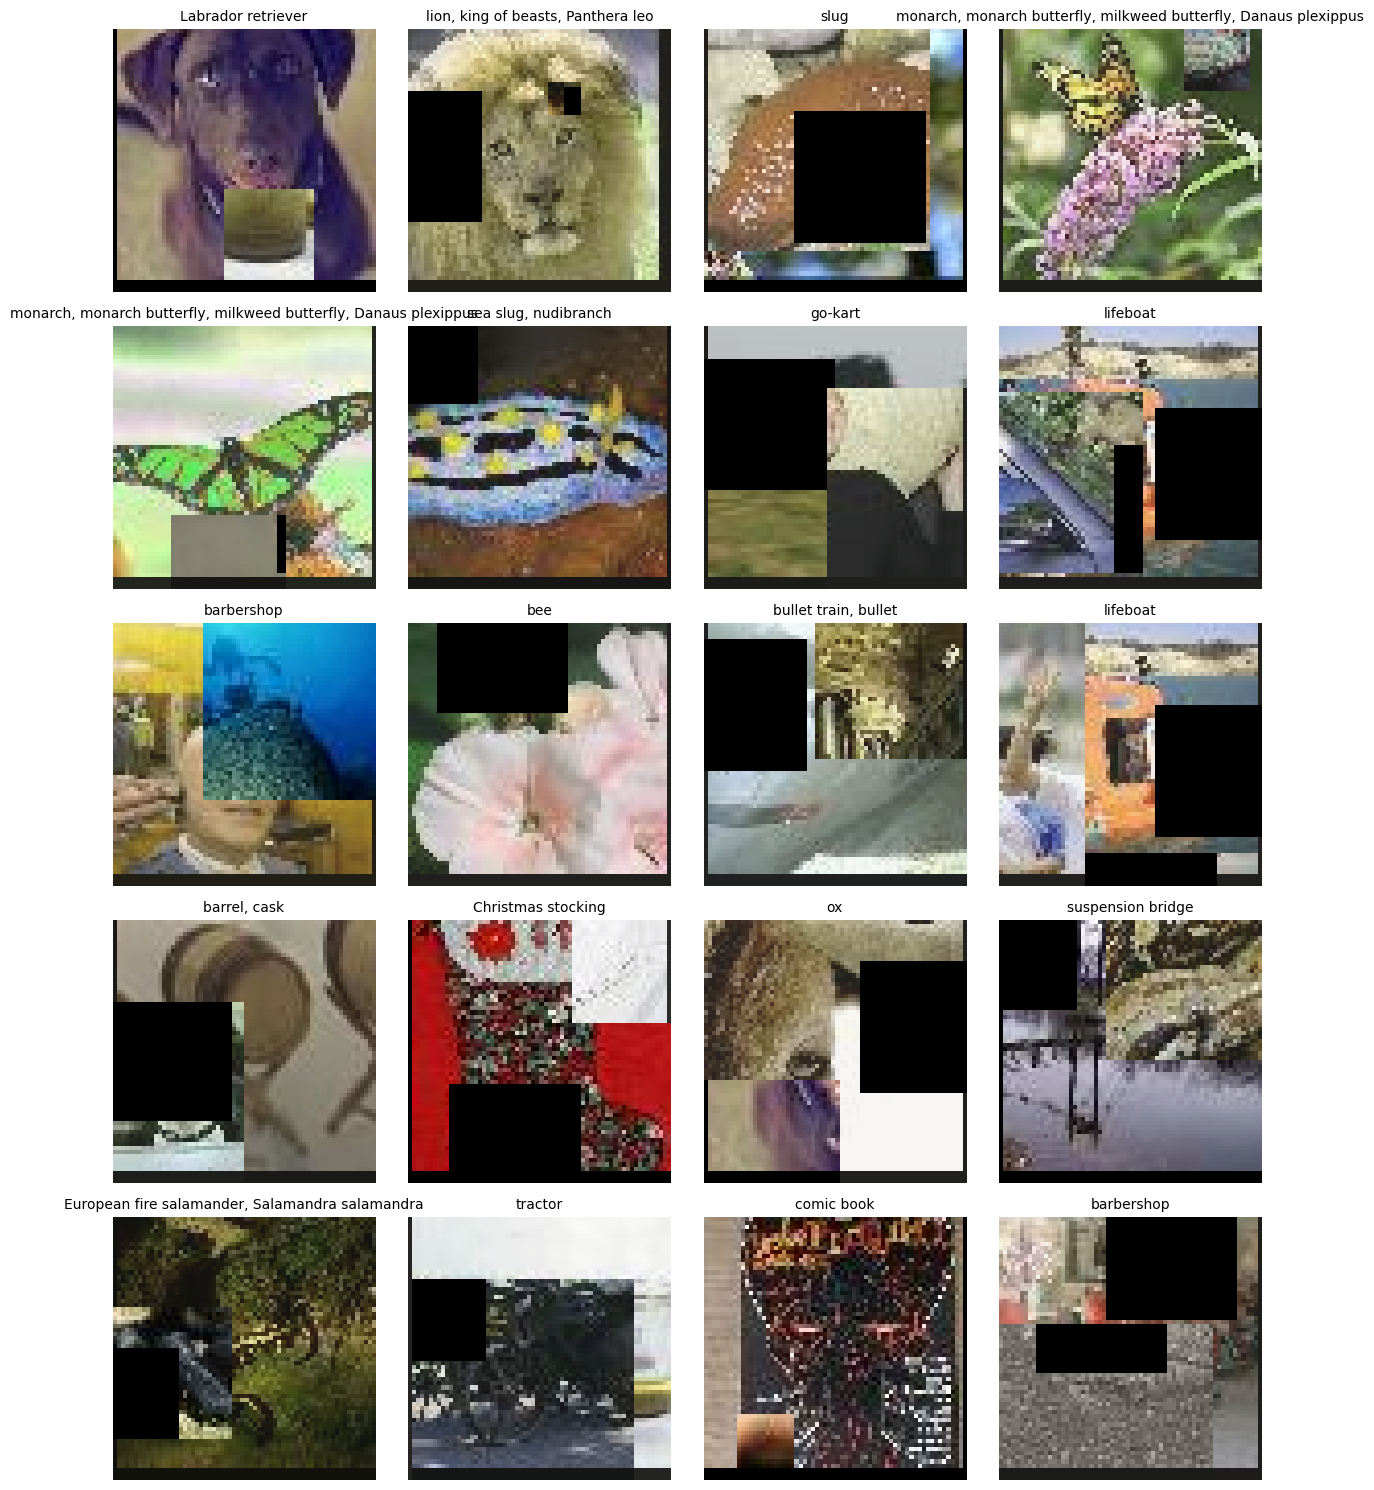

In [8]:
def plot_n_images(n=9):
    images, labels = next(iter(train_ds))

    n = min(n, images.shape[0])
    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(n):
        image = tf.cast(images[i], tf.float32)

        # Undo normalization
        image = image * IMAGENET_STD + IMAGENET_MEAN
        image = tf.clip_by_value(image, 0.0, 1.0)

        label = labels[i].numpy().argmax()  # Correct for sparse labels
        class_id = index_to_class[label]
        class_name = class_to_names[class_id]

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"{class_name}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_n_images(20)


### ConvMixer Model Definition

In [9]:
# ----------------------------
# Build MLP-Mixer
# ----------------------------
# ShufflePatching

def build_mlp_mixer(
    image_size=64,
    num_classes=200,
):

    inputs = keras.Input(shape=(image_size, image_size, 3))
    x = inputs

    x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.Activation("gelu")(x)
    x = layers.BatchNormalization()(x)

    for _ in range(2):
        x = ConvMixer(128, {'kernel_size': 9}, 'depthwise', False)(x)

    x = GroupConv2D(128, 256, kernel_size=5, strides=2, padding='same', use_bias=False, groups=8)(x)
    x = layers.Activation("gelu")(x)
    x = layers.BatchNormalization()(x)

    for _ in range(3):
        x = ConvMixer(256, {'kernel_size': 3, 'axial_kernel_size': 7}, 'mixed', True)(x)

    x = GroupConv2D(256, 512, kernel_size=5, strides=2, padding='same', use_bias=False, groups=8)(x)
    x = layers.Activation("gelu")(x)
    x = layers.BatchNormalization()(x)
    
    for _ in range(5):
        x = ConvMixer(512, {'axial_kernel_size': 5}, 'axial_depthwise', True)(x)


    # Head
    x = tf.reduce_mean(x, axis=[1, 2])  # global average over tokens
    outputs = layers.Dense(num_classes)(x)

    return keras.Model(inputs, outputs, name="mlp_mixer_tinyimagenet")

In [10]:
EPOCHS = 100

model = build_mlp_mixer(
    image_size=64,
    num_classes=200
)

callbacks = [
    CosineAnnealingScheduler(
        base_lr=3e-3,
        min_lr=1e-5,
        epochs=EPOCHS,
        warmup_epochs=5
    )
]

# ----------------------------
# Compile with AdamW
# ----------------------------
optimizer = tfa.optimizers.AdamW(
    learning_rate=3e-3,
    weight_decay=1e-5,
    beta_1=0.9,
    beta_2=0.999
)


model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3))
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.0),
    metrics=['accuracy']
)

model.summary()

Model: "mlp_mixer_tinyimagenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       9600      
                                                                 
 activation (Activation)     (None, 32, 32, 128)       0         
                                                                 
 batch_normalization (Batch  (None, 32, 32, 128)       512       
 Normalization)                                                  
                                                                 
 conv_mixer (ConvMixer)      (None, 32, 32, 128)       27904     
                                                                 
 conv_mixer_1 (ConvMixer)    (None, 32, 32, 128)       27904     
                                            

In [ ]:
model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks) 
"""Results in result/base_conv_mixer.txt"""

> [LR Scheduler] epoch 1: lr=0.000600 (warmup)
Epoch 1/100


2026-02-01 09:41:35.923371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 